Before you run the code, make sure the runtime type is GPU (Runtime -> Change runtime type -> GPU).

In [1]:
%%capture 
!pip install robustness
!git clone https://github.com/MadryLab/BCS_Tutorial.git code
!mv code/*.py .
!wget http://people.csail.mit.edu/shibani/tutorial.zip
!unzip tutorial
!mv tutorial/* .

In [2]:
!ls 

code  data  models  sample_data  tutorial  tutorial.zip  utils.py


In [4]:
try: # set up path
    import google.colab, sys, torch
    if not torch.cuda.is_available():
        print("Please change runtime type to include a GPU.")  
except:
    pass

In [5]:
# Import basic libraries needed for the exercise (numpy, matplotlib, and torch)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch as ch
import torchvision.transforms as transforms

# We also use the robustness library (https://robustness.readthedocs.io/en/latest/) for some 
# convenient functionality.
from robustness.tools.vis_tools import show_image_row

import utils 

sns.set_style('darkgrid')
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Setup

### Load datasets

For our experiments (except Ex. II), we will use the ImageNet dataset from the ILSVRC challenge. This is a 1000 class dataset, that has played an important role in developing and evaluating deep learning models.

In [6]:
# Creater a dataset, and a loader to access it. In addition to the loader, we also need to obtain a
# normalization function. This is because standard deep networks are typically trained 
# on normalized images, so we need to apply the same normalization during testing. Finally,
# we also get a label map, that tells us what class a corresponding numeric value corresponds
# to.
in_dataset, in_loaders, normalization_function, label_map_IN = utils.load_dataset('imagenet',
                                                                 batch_size=5,
                                                                 num_workers=1)
in_loader = in_loaders[1]

==> Preparing dataset imagenet..


We can visualize some samples, along with their labels, from ImageNet as follows

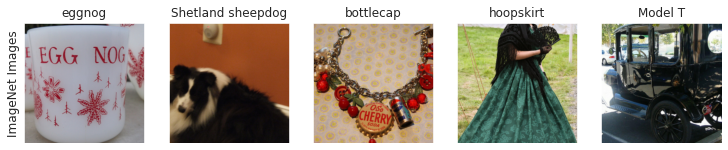

In [7]:
_, (img, targ) = next(enumerate(in_loader))

show_image_row([img],
              ["ImageNet Images"],
              tlist=[[label_map_IN[int(t)].split(',')[0] for t in targ]])

## Load model

Next, we need a model to play with! PyTorch provides access to a large range of pre-trained deep networks (for a full list, see <https://pytorch.org/docs/stable/torchvision/models.html>). For example, we can load a ResNet18 using the following code.

In [8]:
std_model = utils.load_model('resnet18')

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


# Excercise I: Adversarial examples

Since their discovery, adversarial examples have been one of the most extensively studied phenomena in deep learning. Adversarial perturbations are *imperceptible* (non-random) perturbations that can be added to any input image so as to cause a standard (highly accurate) classifier to misclassify the modified input (or classify it as an adversarially chosen class). 

*Finding adversarial examples:* The idea is pretty simple: given a target class (t), we want to find a perturbation ($\delta'$) that when added to the input (x) maximizes the likelihood of the target class. At the same time, we want the perturbation to be small or lie within some pre-defined perturbation set: for example in a tiny L2 ball around the image. Basically, we want to find a $\delta'$ such that

$\delta' = argmax_{||\delta||_2 \leq \epsilon} L(x + \delta, t; \theta)$


To find a perturbation that maximizes the objective (likelihood) while remaining in a bounded set, we use projected gradient descent PGD (see <https://arxiv.org/abs/1706.06083> for more). 

### Try it yourself! 

First choose a target class for every input. (Note that you have a batch of inputs, so you could try different targets for different inputs.)

In [9]:
TARGET = 3

print(f"Target class: {label_map_IN[TARGET]}")

target_class = TARGET * ch.ones_like(targ)

Target class: tiger shark, Galeocerdo cuvieri


Next, there are a couple of parameters that you need to choose: 
1. eps: maximum size of the perturbation in terms of L2 norm. For e.g., eps=2 implies that $||\delta||_2 \leq 2$
2. Nsteps: number of (projected) gradient descent to perform
3. step_size: size of each step of (projected) gradient descent

Try varying these parameters and see what happens.

(You could also try implementing the PGD function yourself!)

In [10]:
# Create adversarial examples
adv_ex = utils.L2PGD(std_model, img, target_class, normalization_function,
                       step_size=0.5, Nsteps=20, 
                       eps=1.25, targeted=True)

Loss: 0.7208504676818848: 100%|██████████| 20/20 [00:01<00:00, 17.15it/s]


### Evaluate model predictions at perturbed inputs

To see if our attack was successful, we will now evaluate model predictions at the perturbed inputs. We would expect the predicted label to match the `target_class` used above, if we succeeded.

In [11]:
with ch.no_grad():
    logits = utils.forward_pass(std_model, 
                                      adv_ex, 
                                      normalization_function)
    pred_label = logits.argmax(dim=1)

### Visualize adversarial examples

We now inspect the original (unperturbed) inputs (*top*), along with the corresponding adversarial examples (*bottom*). We also look at what the model predicts for each row of images.

Does the attack succeed? Do the adversarial examples look different from the original inputs?

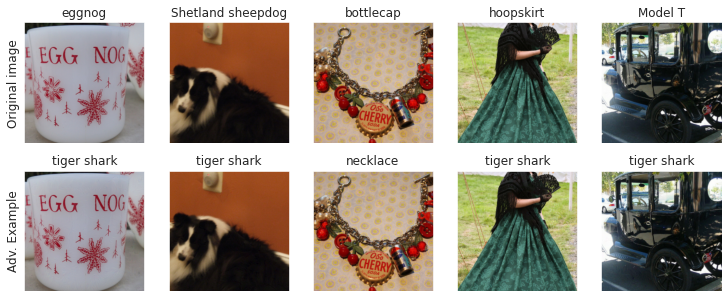

In [12]:
show_image_row([img, adv_ex], 
               ['Original image', 'Adv. Example'],
               tlist=[[label_map_IN[int(t)].split(',')[0] for t in label] \
                      for label in [targ, pred_label, targ]])

# Excercise II: Are adversarial perturbations meaningless?

In this experiment, we will revisit the cause underlying the brittleness of models to adversarial perturbations. In particular, we will examine if adversarial perturbations indeed correspond to meaningless sensitivities (or bugs) in the model.

For computational efficiency, we will perform this experiment using linear classifiers trained on a binary subset of the CIFAR-10 dataset. 


Let's start by loading the dataset and looking at some of its samples.

==> Preparing dataset cifar..


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified




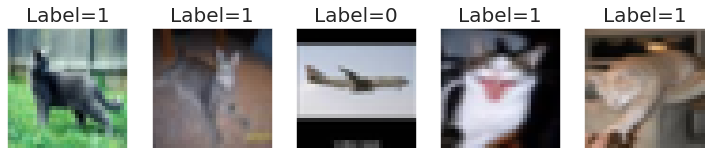

In [13]:
binary_data = utils.load_binary_dataset(batch_size=100, num_workers=1, classes=[0, 3])

im, targ = binary_data['train']
show_image_row([im[:5]],
               tlist=[[f"Label={int(t)}" for t in targ[:5]]],
               fontsize=20)

### Training a linear classifier on this classification task

As you can see, the dataset contains two classes: cats and airplanes. We will now train a very basic linear classifier on the data. 

In [14]:
train_log, linear_net = utils.train_linear(binary_data, step_size=0.1, iterations=2000)

Train accuracy=74.72, Test accuracy=74.90: 100%|██████████| 2001/2001 [01:01<00:00, 32.44it/s]

Final test accuracy: 77.80


If you instead prefer you could also load a pretrained model by remvoving comments from the code below.

In [15]:
load_pretrained = False

if load_pretrained:
    Nfeatures = int(np.prod(binary_data['train'][0].shape[1:]))

    linear_net = utils.Linear(Nfeatures=Nfeatures, Nclasses=2)
    linear_net.load_state_dict(ch.load("./models/LinearCifarBinary.pt"))
    linear_net.eval()
    linear_net = ch.nn.DataParallel(linear_net.cuda())

Let's take a look at some samples from the dataset, along with their labels and model predictions.

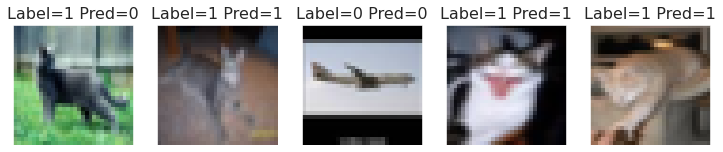

In [16]:
preds = utils.get_predictions(im, linear_net)

show_image_row([im[:5]],
               tlist=[[f"Label={int(t)} Pred={int(p)}" 
                       for t, p in zip(targ[:5], preds[:10])]],
               fontsize=16)

### Using adversarial examples to train models

Note that adversarial examples correspond to adding a non-random perturbation to a given input data point. Thus adversarial perturbations modify input features, albeit in an imperceptible way.

So what features do these perturbations modify? Do they just exploit meaningless sensitivities (or bugs) of the models? What happens if we train a new model solely on adversarial examples?

We will now construct a *training* dataset made of adversarial examples. Specifically, we will:

Step 1. Add adversarial perturbations to all the training set images to fool the linear classifier into flipping its prediction (i.e., classify cats as `0` and airplanes as `1`).

Step 2. We will now take all the successful adversarial examples (i.e., data points that were originally classified correctly by the model, but now after they have been adversarially perturbed) and use these to make a new dataset. The image labels in this dataset will be the labels *predicted* by the model.

In [17]:
im_adv = utils.L2PGD(linear_net, im, targ, None,
                       step_size=0.1, Nsteps=20, 
                       eps=1, targeted=False)

Loss: 8.126799583435059: 100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


Let's look at how many examples we managed to fool the network on and examine some of these samples

% examples on which model is fooled: 56.10 



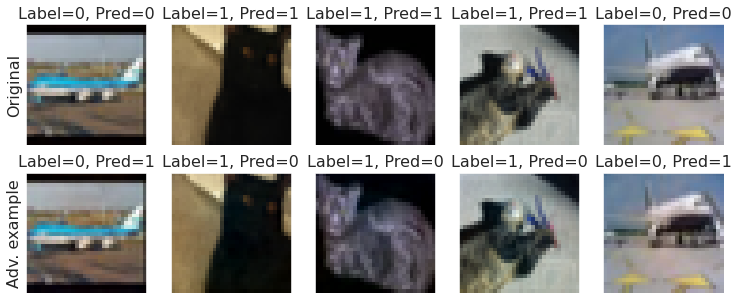

In [19]:
preds_adv = utils.get_predictions(im_adv, linear_net)
print("% examples on which model is fooled:",
      f"{100 * ch.mean(preds_adv.cpu().eq(targ).float()).item():.2f} \n")

idx = np.where(np.logical_and(preds.cpu() == targ, preds_adv.cpu() != targ))[0]
np.random.shuffle(idx)

show_image_row([im[idx[:5]], im_adv[idx[:5]]],
               ylist=["Original", "Adv. example"],
               tlist=[[f"Label={int(t)}, Pred={int(p)}" 
                       for t, p in zip(targ[idx[:5]], preds[idx[:5]])],
                      [f"Label={int(t)}, Pred={int(p)}" 
                       for t, p in zip(targ[idx[:5]], preds_adv[idx[:5]])]],
               fontsize=16)

Note that in the original data, airplanes were labeled as class `0` and cats were labeled as class `1`. However for the adversarial examples, the model predicts the opposite/incorrect label.

We will now train a *new* model on these adversarial examples. Note crucially, that the data points are labeled based on the *predicted label* and hence the labels are flipped w.r.t. the original train/test set.

In [20]:
binary_data_adv = {}
# Training data not consists solely of adv. examples which fooled the model 
# and their "incorrect" labels (airplanes -> 1 and cats -> 0)
binary_data_adv['train'] = (im_adv[idx].cpu(), preds_adv[idx].cpu())
# Test data remains the same (i.e., airplanes -> 0 and cats -> 1)  
binary_data_adv['test'] = binary_data['test']

# The train set size is smaller because we only choose the training samples we are able to fool the model on
print(binary_data_adv['train'][0].shape)

torch.Size([2178, 3, 32, 32])


Let's look again at the training and test data
* If you, as a human, were trained on the samples in the second row in the figure above what mapping would you learn between [cats, airplanes] and labels [0, 1]?
* What would your accuracy on the original (unmodified) test set be?

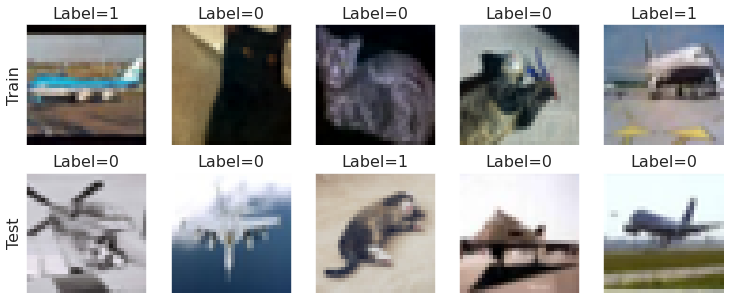

In [21]:
show_image_row([binary_data_adv['train'][0][:5], binary_data_adv['test'][0][:5]],
               ylist=["Train", "Test"],
               tlist=[[f"Label={int(t)}" for t in binary_data_adv['train'][1][:5]],
                      [f"Label={int(t)}" for t in binary_data_adv['test'][1][:5]]],
               fontsize=16)

We will now train a linear classifier from scratch on this mislabelled dataset.

In [22]:
train_log_adv, adv_net = utils.train_linear(binary_data_adv, step_size=0.1, iterations=3000)

Train accuracy=100.00, Test accuracy=76.20: 100%|██████████| 3001/3001 [00:26<00:00, 115.25it/s]


Final test accuracy: 74.45


The model still gets > 70% accuracy on the original, unmodified test set, despite being trained on an entirely mislabeled training set!

Let's look at the predictions of this model to be sure.

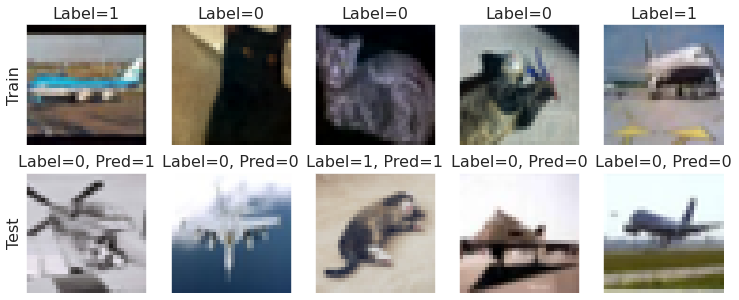

In [23]:
preds = utils.get_predictions(binary_data_adv['test'][0], linear_net)


show_image_row([binary_data_adv['train'][0][:5], binary_data_adv['test'][0][:5]],
               ylist=["Train", "Test"],
               tlist=[[f"Label={int(t)}" for t in binary_data_adv['train'][1][:5]],
                      [f"Label={int(t)}, Pred={int(p)}" 
                       for t, p in zip(binary_data_adv['test'][1][:5], preds[:5])]],
               fontsize=16)

So how did this happen? 

Note that all the human meaningful features, which we refer to as robust features, in these images point to the incorrect label (e.g., wings -> 1 and ears -> 0). Thus, a human trained on the dataset above would get 0% accuracy on the test set.

Since it is not possible to get non-trivial accuracy on the test set based on robust features, this must be due to the (imperceptible) features we introduced via adversarial perturbations. For instance, when we added adversarial perturbations to a cat image to make the first linear classifier think it was a plane, we must have added features that actually generalize to planes on the test set. 

Thus, adversarial examples do not correspond just to meaningless sensitivies but to well-generalizing features. We see this phenomenon occur on state-of-the-art deep nets and on multi-class datasets such as CIFAR or ImageNet. You could try to reproduce this effect there as a follow-up exercise!

# Excercise III: Gradients as model interpretations

So far, we saw that standard models rely on non-robust features for part of their performance. We will now explore how this dependence affects other properties of standard models, specifically model interpretability.

For this, we will begin by looking at one of the most natural interpretations: gradient-based saliency maps. These maps highlight which input features (pixels) the model prediction is sensitive to.

(In these experiments, we will go back to the ImageNet-trained ResNet model from Ex. I.)

### Compute and visualize gradient

In [25]:
_, (img, targ) = next(enumerate(in_loader))

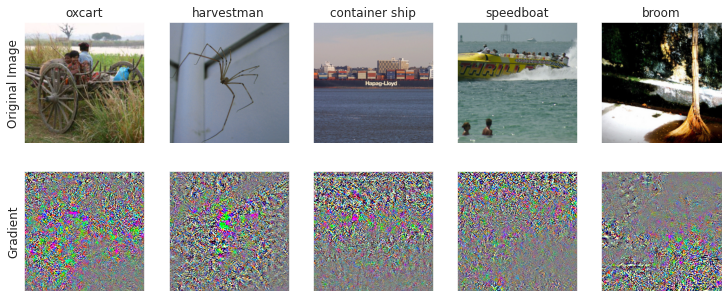

In [26]:
# We compute the gradient of the loss, with respect to the input. For every image pixel,
# the gradient tells us how the loss changes if we vary that pixel slightly.

grad, _ = utils.get_gradient(std_model, img, targ, normalization_function)

# We can then visualize the original image, along with the gradient. Note that the gradient may
# not lie within the valid pixel range ([0, 1]), so we need to rescale it using the 
# `visualize_gradient` function.

show_image_row([img, utils.visualize_gradient(grad)],
              ["Original Image", "Gradient"],
              tlist=[[label_map_IN[int(t)].split(',')[0] for t in targ],
                     ["" for _ in targ]])

The gradients of standard models look quite noisy and seem rather hard to interpret. Why might this be the case? Could it have something to do with non-robust features?

# Exercise IV:  Try SmoothGrad and visualize the interpretations

Fill in the following skeleton to implement SmoothGrad.

```
def smooth_grad(mod, im, targ, normalization, Nsamples, stdev):
    it = tqdm(enumerate(range(Nsamples)), total=Nsamples)
    total_grad = 0
    for _, n in it:
        ...
        grad, _ = helpers.get_gradient(mod, noised_im, targ, normalization)
        total_grad += grad
    return total_grad / Nsamples
```
    
Then, try using SmoothGrad to interpret a standard model

In [28]:
def smooth_grad(mod, im, targ, normalization,
                Nsamples, stdev):
    # Instead of taking the gradient of a single image, we will take gradients
    # at a bunch of neighborhood points and average their gradients.
    
    it = tqdm(enumerate(range(Nsamples)), total=Nsamples)

    total_grad = 0
    for _, n in it:
        
        # Create a noisy version of the input image
        noise = ch.tensor(np.random.normal(0, stdev, im.shape), dtype=im.dtype)
        noised_im = im + noise
        # Compute gradient at noised version of the image
        grad, _ = utils.get_gradient(mod, noised_im, targ, normalization)
        total_grad += grad
    
    # Return average gradient
    return total_grad / Nsamples

In [29]:
sgrad = smooth_grad(std_model, img, targ, normalization_function,
                    100, 0.3)

100%|██████████| 100/100 [00:07<00:00, 13.88it/s]


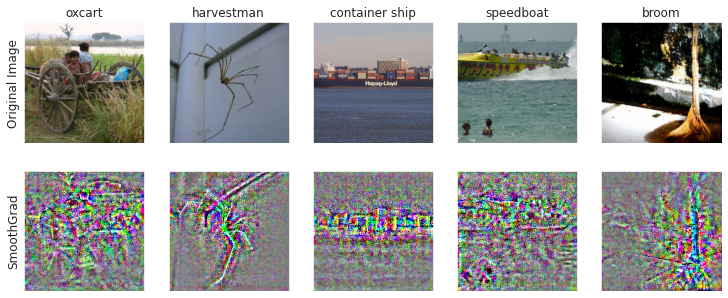

In [30]:
# We once again use the `visualize_gradient` helper to make the SmoothGrad suitable for 
# visualization.

show_image_row([img, utils.visualize_gradient(sgrad)],
              ["Original Image", "SmoothGrad"],
               tlist=[[label_map_IN[int(t)].split(',')[0] for t in targ],
                     ["" for _ in targ]])

Explanations based on SmoothGrad align much better with features that we humans might use to make predictions. But what did we actually fix in smoothing the gradients? Were vanilla gradients just overly sensitive and noisy? Or did we maybe mask some  features that the models actually rely on to get cleaner interpretations?

# Excercise V: Playing with robust models

The existance of adversarial examples has also prompted a large body of research to build models that are robust to these perturbations, i.e., so-called *robust models*. One approach to get a robust model is to train against the PGD adversary: instead of minimizing the loss over training examples, we minimize the loss against adversarially perturbed training samples (obtained using PGD). We will now take a closer look at robust models.

### Loading a robust model

For our study today, we will use a pre-trained robust model. We trained this model (ResNet50) on a 9-class subset of the ImageNet dataset. (Developing good robust models for the more complex 1000 class version is still an active area of research.)

In [43]:
# Load the "Restricted" ImageNet dataset
restricted_imagenet_ds, rin_loaders, normalization_function, label_map_RIN = \
            utils.load_dataset('restricted_imagenet', batch_size=5, num_workers=1)

rin_loader = rin_loaders[1]    
# Load a pre-trained robust model
#robust_model = utils.load_model('robust', restricted_imagenet_ds)
robust_model = utils.load_model('robust', restricted_imagenet_ds)

==> Preparing dataset restricted_imagenet..
=> loading checkpoint './models/RestrictedImageNet.pt'
=> loaded checkpoint './models/RestrictedImageNet.pt' (epoch 61)


### Can adversarial examples fool a robust model?

We can now try to fool the robust model using the same procedure as before. Does it succeed? Try varying the attack parameters and see what happens.

Loss: 11.39222526550293:   5%|▌         | 1/20 [00:00<00:02,  8.76it/s]

Target class: turtle


Loss: 10.229849815368652: 100%|██████████| 20/20 [00:01<00:00, 12.77it/s]


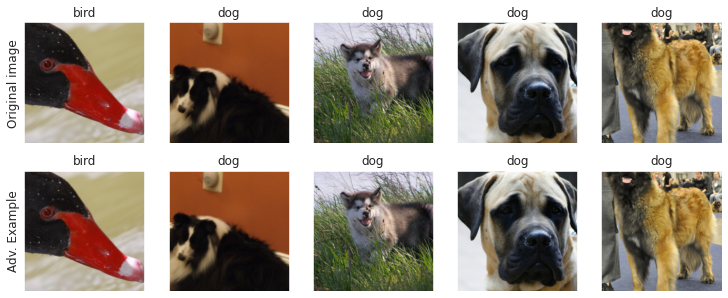

In [44]:
# Load images from the Restricted ImageNet dataset
_, (img, targ) = next(enumerate(rin_loader))

# Then we choose a target label for the attack.
TARGET = 3

print(f"Target class: {label_map_RIN[TARGET]}")

target_class = TARGET * ch.ones_like(targ)

# Create adversarial examples
adv_ex = utils.L2PGD(robust_model, img, target_class, normalization_function,
                       step_size=0.5, Nsteps=20, eps=1.25, targeted=True)

# Evaluate model predictions
with ch.no_grad():
    logit = utils.forward_pass(robust_model, adv_ex, normalization_function)
    pred_label = logit.argmax(dim=1)

# Visualize adversarial examples

show_image_row([img, adv_ex], 
               ['Original image', 'Adv. Example'],
               tlist=[[label_map_RIN[int(t)].split(',')[0] for t in label] \
                      for label in [targ, pred_label]])

### Changing the prediction of a robust model

We know that robust models are not easily fooled by adversarial examples. This tells us that one cannot change the prediction of a robust model using imperceptible L2 perturbations to the input (in contrast to standard models). How can we then modify the input to make the robust model predict a different class?

Try creating adversarial examples as before, but with a larger eps. Our hope is that by increasing the size of the perturbation set, we can find a perturbation that actually causes the model to change its prediction? What do the perturbed inputs, i.e., "*large epsilon adversarial examples*" look like?

In [45]:
TARGET = 5

print(f"Target class: {label_map_RIN[TARGET]}")

target_class = TARGET * ch.ones_like(targ)

im_targ = utils.L2PGD(robust_model, img, target_class, normalization_function,
                        step_size=5, Nsteps=20, eps=100, targeted=True)

# Evaluate model predictions
with ch.no_grad():
    logit = utils.forward_pass(robust_model, im_targ, normalization_function)
    pred_label = logit.argmax(dim=1)

Loss: 9.015066146850586:   5%|▌         | 1/20 [00:00<00:02,  8.80it/s]

Target class: primate


Loss: 0.0: 100%|██████████| 20/20 [00:01<00:00, 12.82it/s]


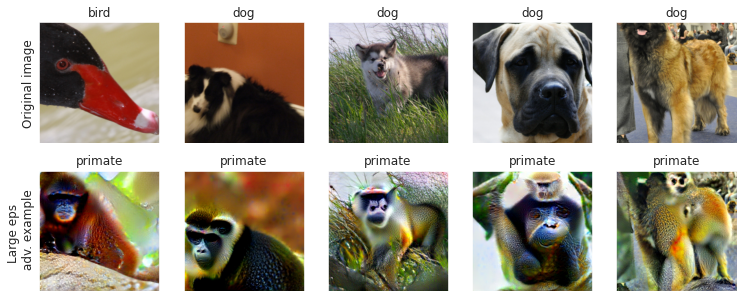

In [46]:
show_image_row([img, im_targ],
              ['Original image', 'Large eps \n adv. example'],
               tlist=[[label_map_RIN[int(t)].split(',')[0] for t in label] \
                      for label in [targ, pred_label]])

# Excercise VI: Interpretations for robust models

Based on the previous experiment, we know that, for robust models, (a) imperceptible input changes do not change the prediction and (b) to change the prediction, we actually need to change "salient image features".

Does this mean that the features that robust models rely on are more human-aligned in a sense?

### VI.I Let's start by looking at their gradients.

What do the gradients of robust models look like? How do they compare to the gradients of a standard model and the output of SmoothGrad?

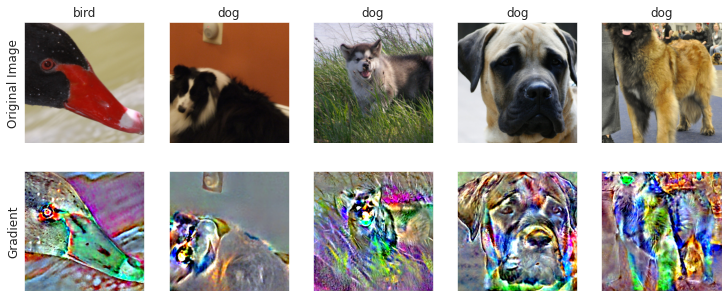

In [47]:
# Get gradient of the loss with respect to the input
grad_rob, _ = utils.get_gradient(robust_model, img, targ, normalization_function)

# Visualize gradient
show_image_row([img, utils.visualize_gradient(grad_rob)],
              ["Original Image", "Gradient"],
              tlist=[[label_map_RIN[int(t)].split(',')[0] for t in targ],
                     ["" for _ in targ]])

### VI.2 Feature Visualization

Another popular interpretability technique is known as feature visualization. Here, the goal is to find an input that maximizes a feature (a particular neuron in the deep network), instead of just trying to maximize the loss (as we did before with gradients).

You could now try to implement feature visualization yourself. For instance, the following function gives you, for specific inputs, the model's feature vector (the layer before the final linear classifier). 

In [48]:
# Getting the feature representation from the model
with ch.no_grad():
    feats = utils.get_features(robust_model, img, normalization_function)
    print(f"Dimensions of the feature vector: {feats.shape[1]}")

Dimensions of the feature vector: 2048


#### Implement a loss function to perform feature visualization

Fill in the skeleton below to create a feature visualization loss function. Our goal is to maximize the `feature_number` coordinate of the feature vector.

```
def feature_maximization_loss(mod, im, feature_number, normalization_function):
    feature_vector = helpers.get_features(mod, im, normalization) # Get features for input
    relevant_coordinate = ch.gather(feature_vector, 1, feature_number[:, None]) 
    loss = ?
    ...
    return loss
```

In [49]:
# Feature visualization loss: Try to find an input that maximizes a specific feature

def feature_maximization_loss(mod, im, feature_number, normalization):
    # Get feature vector for inputs
    fr = utils.get_features(mod, im, normalization)
    # We will maximize the `targ` coordinate of the feature vector for every input
    loss = ch.mean(ch.gather(fr, 1, feature_number[:, None]))
    return loss

#### Visualize the results of feature visualization

You can then supply the `feature_maximization_loss` to the `custom_loss` argument input in `helpers.L2PGD`, and maximize it using the following snippet.

In [50]:
# Chose a feature to visualize
FEATURE = 200 # should be less than the dimension from before

target_feature = FEATURE * ch.ones_like(targ)

In [51]:
# Maximize feature 
im_f = utils.L2PGD(robust_model, img, target_feature, normalization_function,
                              step_size=5, Nsteps=20, eps=1000, 
                              custom_loss=feature_maximization_loss, 
                              targeted=False)

Loss: 1.496112585067749: 100%|██████████| 20/20 [00:01<00:00, 12.80it/s]


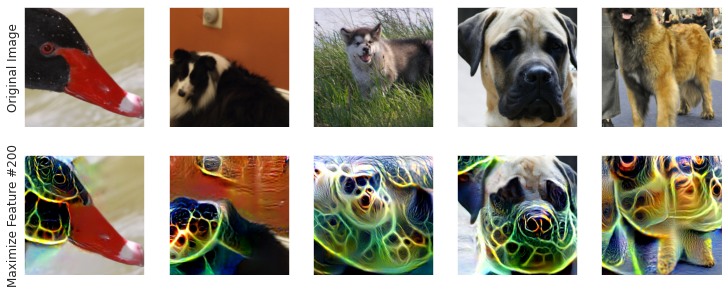

In [52]:
# Visualize results
show_image_row([img, im_f],
               ["Original Image", f"Maximize Feature #{FEATURE}"])

#### Try the same for a standard model

In [53]:
# Load image-label pair from ImageNet
_, (img, targ) = next(enumerate(in_loader))

TARGET = 100 
target_feature = TARGET * ch.ones_like(targ)
im_f = utils.L2PGD(std_model, img, target_feature, normalization_function,
                              step_size=5, Nsteps=20, eps=1000, 
                              custom_loss=feature_maximization_loss, 
                              targeted=False)

Loss: 48.00407409667969: 100%|██████████| 20/20 [00:00<00:00, 21.65it/s]


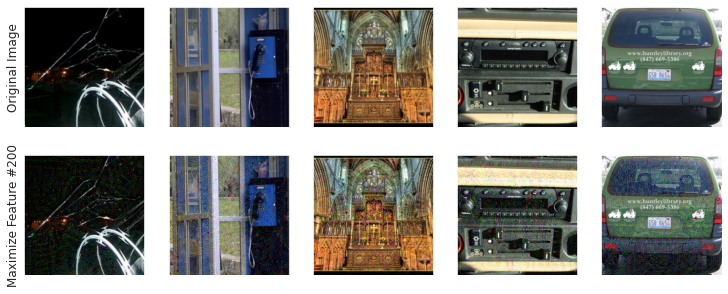

In [54]:
show_image_row([img, im_f],
               ["Original Image", f"Maximize Feature #{FEATURE}"])

# Bonus Excercise I: Try feature visualization for robust models starting from noise rather than images

What if we try feature visualization starting from noise?

In [55]:
# Create a "noise" image
noise_img = ch.clamp(ch.randn_like(img) + 0.5, 0, 1)

FEATURE = 201
target_feature = FEATURE * ch.ones_like(targ)
im_f = utils.L2PGD(robust_model, noise_img, target_feature, normalization_function,
                     step_size=5, Nsteps=200, eps=1000, 
                     custom_loss=feature_maximization_loss, 
                     targeted=False)

Loss: 2.8149101734161377: 100%|██████████| 200/200 [00:14<00:00, 13.81it/s]


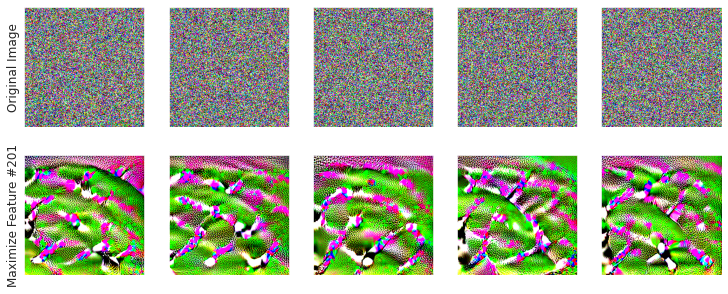

In [56]:
show_image_row([noise_img, im_f],
                ["Original Image", f"Maximize Feature #{FEATURE}"])